<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab7.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Lab 7: The Transformer
### Description:
For this lab, you will fill in the attention mechanism for the Transformer architecture. 

There are three parts of this lab:
1. Implement scaled dot-product attention
2. Implement a multi-headded attention mechanism
3. Translate general conference!


### Grading standards

Your code will be graded on the following:

- 45% Implementation of scaled dot-product attention
- 45% Implementation of multi-headed attention mechanism
- 10% Reasonable translation of general conference

Note: This lab was adapted from "The Annotated Transformer", a publically available PyTorch implementation of the Transformer. This lab only requires about 20 lines of code, but we want you to think hard about the dimensions on which different operations apply, and debug accordingly. This will be trivial if you use the implementation for reference, but will be a worthwhile learning exercise if you don't. So we ask you not to reference that particular implementation, though you are free to reference other implementations (see references below).

    
### Tips:
A couple of tips for this lab:
0. The provided code instantiates the `MultiHeadedAttention` class for you. For a start, try printing the dimensions of `key`, `query`, and `values` in the `forward()` function the `MultiHeadedAttention` class.
1. The key to this lab is section 3.2 of "Attention is All you Need". This section will tell you pretty much all you need to know about dimensions. https://arxiv.org/pdf/1706.03762.pdf
2. The queries, keys, and values come in the form N x L x d_model, where N is the batch size, L is the sentence length, and d_model is the dimension of the embedding. Both the batch size and the sentence length vary across training instances.
3. There are 3 pytorch implementations of matrix multiplication: torch.bmm, torch.mm, and torch.matmul. You'll want to figure out which one to use for this lab.
4. There are 3 pytorch implementations of transpose: torch.t, torch.transpose, and torch.permute. You'll want to figure out which one of those to use as well.
5. This implementation provides a `clone()` function that you may find useful in the MultiHeadedAttention class

### Example Output
An example of my final samples are shown below, after 3 epochs through the data. You should expect each epoch to take ~10 minutes, and should see reasonable results after the first epoch.

Spanish:	Muchos miembros de la Iglesia tuvieron fe en las profecías de Brigham Young , mientras que otros se mostraron escépticos y partieron hacia lo que ellos creían que sería una vida mejor . 

Translation:	Many members of the Church had faith in Brigham Young , while others who showed and other mocking to what they would be better than they would be better better than they would better . 

Target:		Many Church members had faith in Brigham Young ’s prophecies , while others remained <unk> and left for what they assumed would be a better life . 

### Based on "Attention is All You Need" (https://arxiv.org/abs/1706.03762) and "The Annotated Transformer" (https://nlp.seas.harvard.edu/2018/04/03/attention.html)
### Also useful:
http://jalammar.github.io/illustrated-transformer/

https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/


## Setup


In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

# Download english and spanish vocab and general conference texts
!pip install torchtext spacy
!python -m spacy download en
!python -m spacy download es
!wget  -O ./spanish "https://raw.githubusercontent.com/nickwalton/translation/master/gc_2010-2017_conglomerated_20171009_es.txt"
!wget -O ./english "https://raw.githubusercontent.com/nickwalton/translation/master/gc_2010-2017_conglomerated_20171009_en.txt"

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')
--2020-10-23 14:46:23--  https://raw.githubusercontent.com/nickwalton/translation/master/gc_2010-2017_conglomerated_20171009_es.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8617078 (8.2M) [text/plain]
Savin

#Model

## Model Helpers


In [29]:
class PositionwiseFeedForward(nn.Module):
    "Simple linear layers with dropout and relu"
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
class Embeddings(nn.Module):
    "Create word embeddings"
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)
    
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

class LayerNorm(nn.Module):
    "Construct a layernorm module "
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))
    
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

## Encoder

The encoder is composed of a stack of $N=6$ identical layers. 

In [30]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


    
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward "
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

## Decoder

The decoder is also composed of a stack of $N=6$ identical layers.  


In [31]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)
    
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)
    
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

##Implement Attention


https://arxiv.org/pdf/1706.03762.pdf         
                                                                                                                                                                     

In [32]:
def attention(query, key, value, mask):
    # Compute 'Scaled Dot Product Attention'
    print_size = False
    if print_size:
      print(query.size())
      print(key.size())
      print(value.size())
    
    # scores = QK^T/scale
    scale = key.size()[-1]
    scores = torch.bmm(query, key.permute(0, 2, 1))
    scores = scores / math.sqrt(scale)

    if print_size:
      print(scores.size())
      print(mask.size())
    
    # Apply the mask
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
        
    # output = softmax(scores)(V)
    output = torch.matmul(F.softmax(scores, dim=2), value)
    
    return output

In [33]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        # Implement Multi-head attention mechanism
        
        # Make an attention head (linear layers for q, k, and v)
        
        # Make h copies of the attention head (Hint: See the `clone()` helper function)
        self.head_weights = clones(nn.Linear(d_model, d_model), h)
        
        # etc.

    def forward(self, query, key, value, mask):
        # For each attention head
            # Pass the query, key, value through their respective layers
            # Compute scaled dot-product attention on the output
        # etc.
        return attention(self.head_weights[0](query), self.head_weights[1](key), self.head_weights[2](value), mask)

## Positional Encoding                                                                                                                             
Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.  To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.  The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.   There are many choices of positional encodings, learned and fixed [(cite)](https://arxiv.org/pdf/1705.03122.pdf). 

In this work, we use sine and cosine functions of different frequencies:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$                                                                                                                                                                                                                                                        
where $pos$ is the position and $i$ is the dimension.  That is, each dimension of the positional encoding corresponds to a sinusoid.  The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.  We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$. 

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.  For the base model, we use a rate of $P_{drop}=0.1$. 
                                                                                                                                                                                                                                                    


In [34]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = 1 / (10000 ** (torch.arange(0., d_model, 2) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

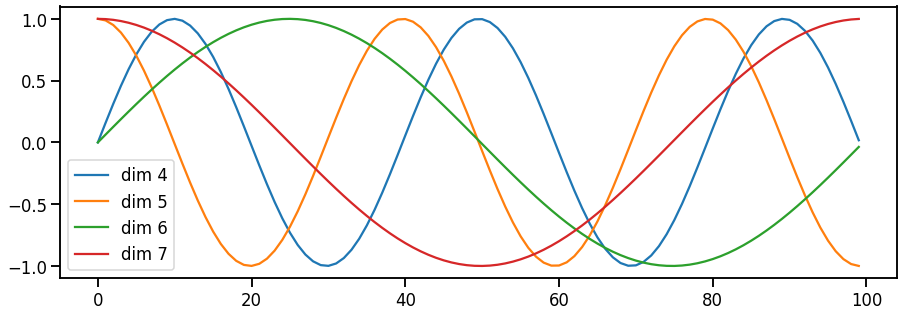

In [35]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

## Full Model

In [36]:
class TransformerModel(nn.Module):
    """
    Full transformer model
    """
    def __init__(self, src_vocab, tgt_vocab, N=6, d_model=256, d_ff=1024, h=8, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        attn = MultiHeadedAttention(h, d_model)
        ff = PositionwiseFeedForward(d_model, d_ff, dropout)
        position = PositionalEncoding(d_model, dropout)
        c = copy.deepcopy
        
        self.encoder = Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N)
        self.decoder = Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N)
        self.src_embed = nn.Sequential(Embeddings(d_model, src_vocab), c(position))
        self.tgt_embed = nn.Sequential(Embeddings(d_model, tgt_vocab), c(position))
        self.generator = Generator(d_model, tgt_vocab)
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

# Training


## Batches and Masking

In [37]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask
    
    
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

## Label Smoothing

During training, we employed label smoothing of value $\epsilon_{ls}=0.1$ [(cite)](https://arxiv.org/abs/1512.00567).  This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.  

In [38]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

## Data Loading


In [39]:
from torchtext import data, datasets
import torchtext
import spacy

# Load spacy tokenizers.
spacy_es = spacy.load('es')
spacy_en = spacy.load('en')

def tokenize_es(text):
    return [tok.text for tok in spacy_es.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = data.Field(tokenize=tokenize_es, pad_token=BLANK_WORD)
TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                 eos_token = EOS_WORD, pad_token=BLANK_WORD)

print("Loading Dataset")
spanish_text = open('./spanish','r')
english_text = open('./english', 'r')
english_lines = list(english_text)
spanish_lines = list(spanish_text)

fields = (["src", SRC], ["trg", TGT])
examples = [torchtext.data.Example.fromlist((spanish_lines[i], english_lines[i]), fields ) for i in range(len(english_lines))]

MAX_LEN = 200
train, val = torchtext.data.Dataset(examples, fields=fields, filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
        len(vars(x)['trg']) <= MAX_LEN).split()

MIN_FREQ = 1
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

Loading Dataset


## Training Code

In [40]:
class LossFunction:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.zero_grad()
        return loss.data * norm

class DataIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1).cuda(), batch.trg.transpose(0, 1).cuda()
    return Batch(src, trg, pad_idx)

    
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens
    

##Train

In [41]:
import gc
gc.collect()

pad_idx = TGT.vocab.stoi["<blank>"]
model = TransformerModel(len(SRC.vocab), len(TGT.vocab), N=2).cuda()
n_epochs = 3
device = torch.device('cuda')

def scope():
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion.cuda()
    BATCH_SIZE = 1000
    train_iter = DataIterator(train, batch_size=BATCH_SIZE, device=device,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = DataIterator(val, batch_size=BATCH_SIZE, device=device,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)

    model_opt = torch.optim.Adam(model.parameters(), lr=5e-4)
    for epoch in range(n_epochs):
        model.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), 
                  model, 
                  LossFunction(model.generator, criterion, model_opt))
        model.eval()
scope()

Epoch Step: 1 Loss: 8.654586 Tokens per Sec: 5566.259277
Epoch Step: 51 Loss: 5.804242 Tokens per Sec: 17327.505859
Epoch Step: 101 Loss: 5.681270 Tokens per Sec: 17251.222656
Epoch Step: 151 Loss: 5.367918 Tokens per Sec: 17804.849609
Epoch Step: 201 Loss: 5.300959 Tokens per Sec: 18170.541016
Epoch Step: 251 Loss: 5.261442 Tokens per Sec: 17402.048828
Epoch Step: 301 Loss: 5.199799 Tokens per Sec: 17226.511719
Epoch Step: 351 Loss: 5.241695 Tokens per Sec: 17552.195312
Epoch Step: 401 Loss: 5.042365 Tokens per Sec: 17140.511719
Epoch Step: 451 Loss: 4.510942 Tokens per Sec: 17617.796875
Epoch Step: 501 Loss: 4.572206 Tokens per Sec: 17177.447266
Epoch Step: 551 Loss: 4.034251 Tokens per Sec: 16967.716797
Epoch Step: 601 Loss: 4.605668 Tokens per Sec: 17374.162109
Epoch Step: 651 Loss: 4.161517 Tokens per Sec: 17974.818359
Epoch Step: 701 Loss: 3.862589 Tokens per Sec: 17421.076172
Epoch Step: 751 Loss: 4.261609 Tokens per Sec: 18118.039062
Epoch Step: 801 Loss: 3.919914 Tokens per Se

## Translate

In [42]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

BATCH_SIZE = 1000
n_train_iters = len(train) / BATCH_SIZE
valid_iter = DataIterator(val, batch_size=BATCH_SIZE, device=device,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)
    
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1].cuda()
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2).cuda()
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
    print("Spanish:", end="\t")
    for i in range(0, src.size(1)):
        sym = SRC.vocab.itos[src[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Target:\t", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print()
    
    if i > 1000 and i<1100:
        break

Spanish:	de Jesús 
Translation:	Jesus of Jesus of Christ 
Target:		See what God hath done . 

Spanish:	Octubre de 2016 
Translation:	October 2016 
Target:		October 2016 

Spanish:	Moisés 1:39 . 
Translation:	Moses 1:39 . 
Target:		Moses 1:39 . 

Spanish:	Guíenme , <unk> 
Translation:	Lead , 
Target:		Lead me , guide me , walk beside me , 

Spanish:	Familias bajo el convenio 
Translation:	Families under the covenant covenant covenant of Families 
Target:		Families under Covenant 

Spanish:	Véase Mosíah 2:22 . 
Translation:	See Mosiah 18:9 . 
Target:		See Mosiah 2:22 . 

Spanish:	Por Linda K. Burton 
Translation:	By Linda K. Burton 
Target:		By Linda K. Burton 

Spanish:	Sentí paz ” . 
Translation:	I felt peace . ” 
Target:		I had peace . ” 

Spanish:	Tienen cinco hijos . 
Translation:	They are the children of the children of the parents of the parents of the parents of the parents of the parents of the parents of the parents of the parents of the parents of the parents of the parents of

<div id="disqus_thread"></div>
<script>
    /**
     *  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
     *  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
     */
    /*
    var disqus_config = function () {
        this.page.url = PAGE_URL;  // Replace PAGE_URL with your page's canonical URL variable
        this.page.identifier = PAGE_IDENTIFIER; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
    };
    */
    (function() {  // REQUIRED CONFIGURATION VARIABLE: EDIT THE SHORTNAME BELOW
        var d = document, s = d.createElement('script');
        
        s.src = 'https://EXAMPLE.disqus.com/embed.js';  // IMPORTANT: Replace EXAMPLE with your forum shortname!
        
        s.setAttribute('data-timestamp', +new Date());
        (d.head || d.body).appendChild(s);
    })();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript" rel="nofollow">comments powered by Disqus.</a></noscript>